In [1]:
# # %pip install pandas
# !pip install boto3 pyarrow
# !pip install matplotlib seaborn
# %pip install scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import warnings
from io import StringIO  
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings('ignore')


In [ ]:
# NO NEED RUN THIS, ALREADY HAVE THE FILES FROM S3

# Define the bucket name and path prefix
bucket_name = 'is459-project-output-data'
prefix_path = 'weather/kaggle/airline_with_weather/'

# Initialize S3 client
s3 = boto3.client('s3')

# List objects in the specified prefix to find the first three Parquet files
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix_path)
parquet_files = []

# Collect the first three Parquet files
for obj in response.get('Contents', []):
    if obj['Key'].endswith('.parquet'):
        parquet_files.append(obj['Key'])
        if len(parquet_files) == 10: 
            break

# Download each Parquet file to the local filesystem
local_files = []
for i, file_key in enumerate(parquet_files):
    local_path = f'file_{i}.parquet'
    s3.download_file(Bucket=bucket_name, Key=file_key, Filename=local_path)
    local_files.append(local_path)

# Read the local files and concatenate them into a single DataFrame
dataframes = [pd.read_parquet(file, engine='pyarrow') for file in local_files]
df = pd.concat(dataframes, ignore_index=True)

# Display the concatenated DataFrame
print("Concatenated DataFrame from the first three Parquet files:")
print(df.head())



In [2]:
#Read first two files only , memory limits
# List of local Parquet file paths
local_files = ['file_0.parquet', 'file_1.parquet']

# Read the local files and concatenate them into a single DataFrame
dataframes = [pd.read_parquet(file, engine='pyarrow') for file in local_files]
df = pd.concat(dataframes, ignore_index=True)

# Display the concatenated DataFrame
print("Concatenated DataFrame from the first three Parquet files:")
print(df.head())


Concatenated DataFrame from the first three Parquet files:
         Date  Year  Month  DayofMonth UniqueCarrier  FlightNum Origin Dest  \
0  2010-08-11  2010      8          11            OO       6582    BUR  SFO   
1  2016-09-05  2016      9           5            AA       2189    DCA  MIA   
2  2017-09-20  2017      9          20            B6        299    LGA  MCO   
3  2013-12-30  2013     12          30            US       1986    LAX  CLT   
4  2014-01-23  2014      1          23            UA       1531    SFO  PDX   

   CRSDepTime  DepTime  ...  temperature_2m  wind_speed_10m  precipitation  \
0        1342   1452.0  ...            14.6             1.8            0.0   
1         630    617.0  ...            17.1             6.4            0.0   
2        1629   1619.0  ...            24.0            24.9            0.0   
3         910    900.0  ...             8.0            10.7            0.0   
4        2013   2015.0  ...            16.7             9.0            0.0  

### EDA

In [3]:
df = df[df['Year'] > 2008]

In [4]:
len(df)

12911862

In [5]:
len(df[df['Cancelled']==1])

209341

In [6]:
len(df[df['CancellationCode']=='B'])

100354

In [7]:
# Drop rows where wlatitude_deg and wlongitude_deg are null
df = df.dropna(subset=['wlatitude_deg', 'wlongitude_deg'])

# # Drop the wlatitude_deg and wlongitude_deg columns
df = df.drop(columns=['wlatitude_deg', 'wlongitude_deg'])
df['SecurityDelay'].fillna(0, inplace=True)
# Confirm the changes
# print("Missing values after dropping rows and columns:")
# print(df.isnull().sum())


## Cancellation

In [8]:
important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSArrTime', 'CRSDepTime',
    'DayofMonth', 'Distance', 'CRSElapsedTime', 'Month', 'Year','precipitation','rain'
]

# Use only the selected important features for training
X_important = df[important_features]
y = df['Cancelled'] 


In [9]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_important, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42, min_samples_split=10, min_samples_leaf=5, max_depth=4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6253944057892623
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.85      0.69     61213
         1.0       0.72      0.40      0.52     60806

    accuracy                           0.63    122019
   macro avg       0.66      0.62      0.61    122019
weighted avg       0.66      0.63      0.61    122019

Confusion Matrix:
 [[51965  9248]
 [36461 24345]]


### Feature importance

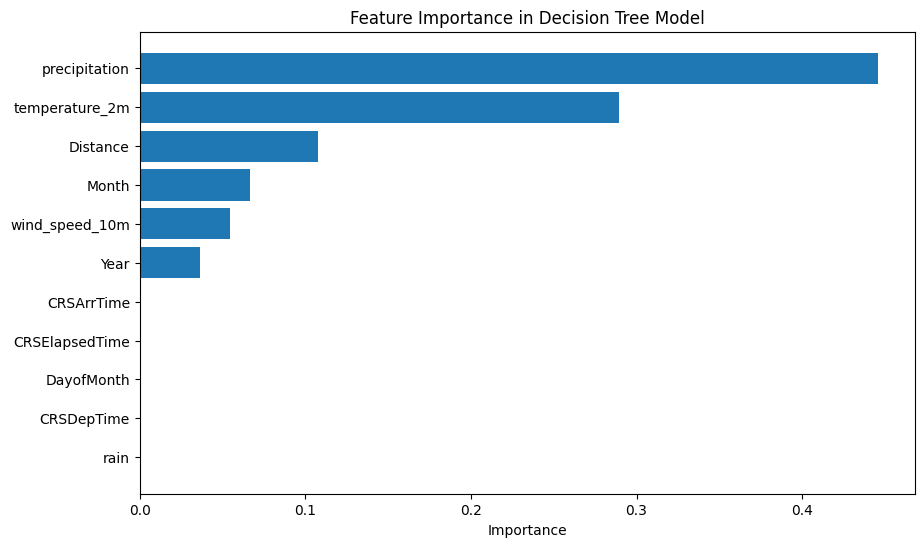

In [11]:

feature_importance = pd.DataFrame({
    'Feature': X_important.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

### Partial Dependency

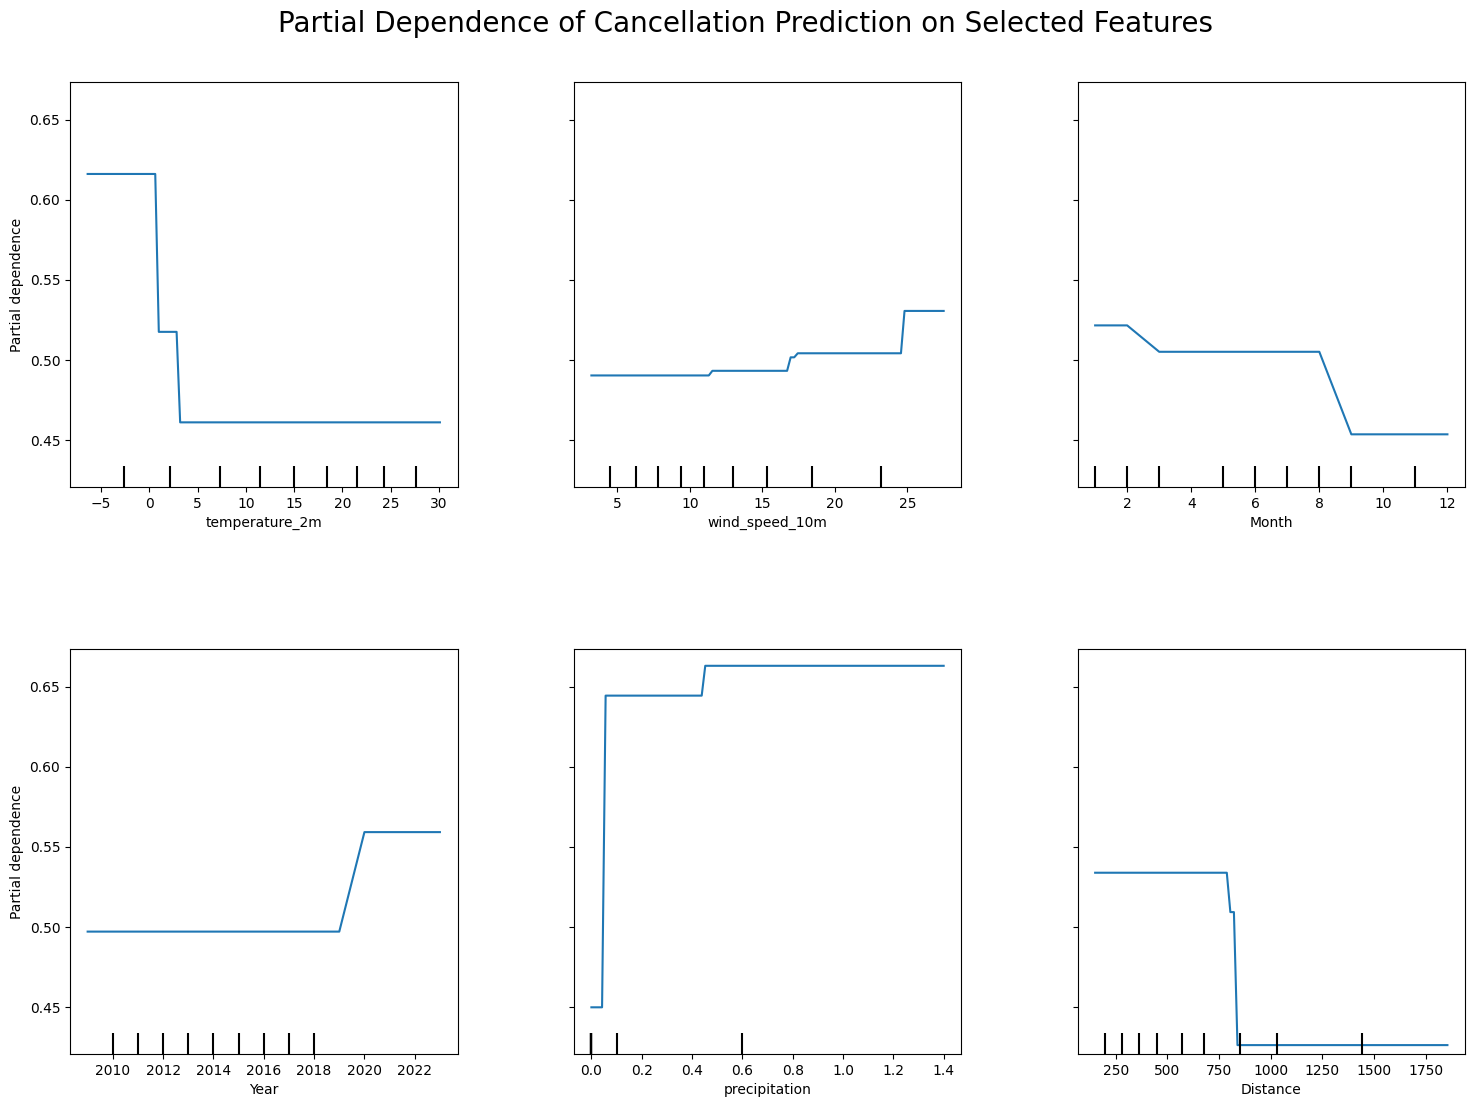

In [12]:

important_features = ['temperature_2m', 'wind_speed_10m', 'Month', 'Year', 'precipitation', 'Distance']


fig, ax = plt.subplots(figsize=(18, 12))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    important_features,
    kind="average",
    n_cols=3, 
    ax=ax
)


plt.suptitle("Partial Dependence of Cancellation Prediction on Selected Features", fontsize=20)
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  # Adjust spacing for clarity


plt.show()



### Model Visualisation

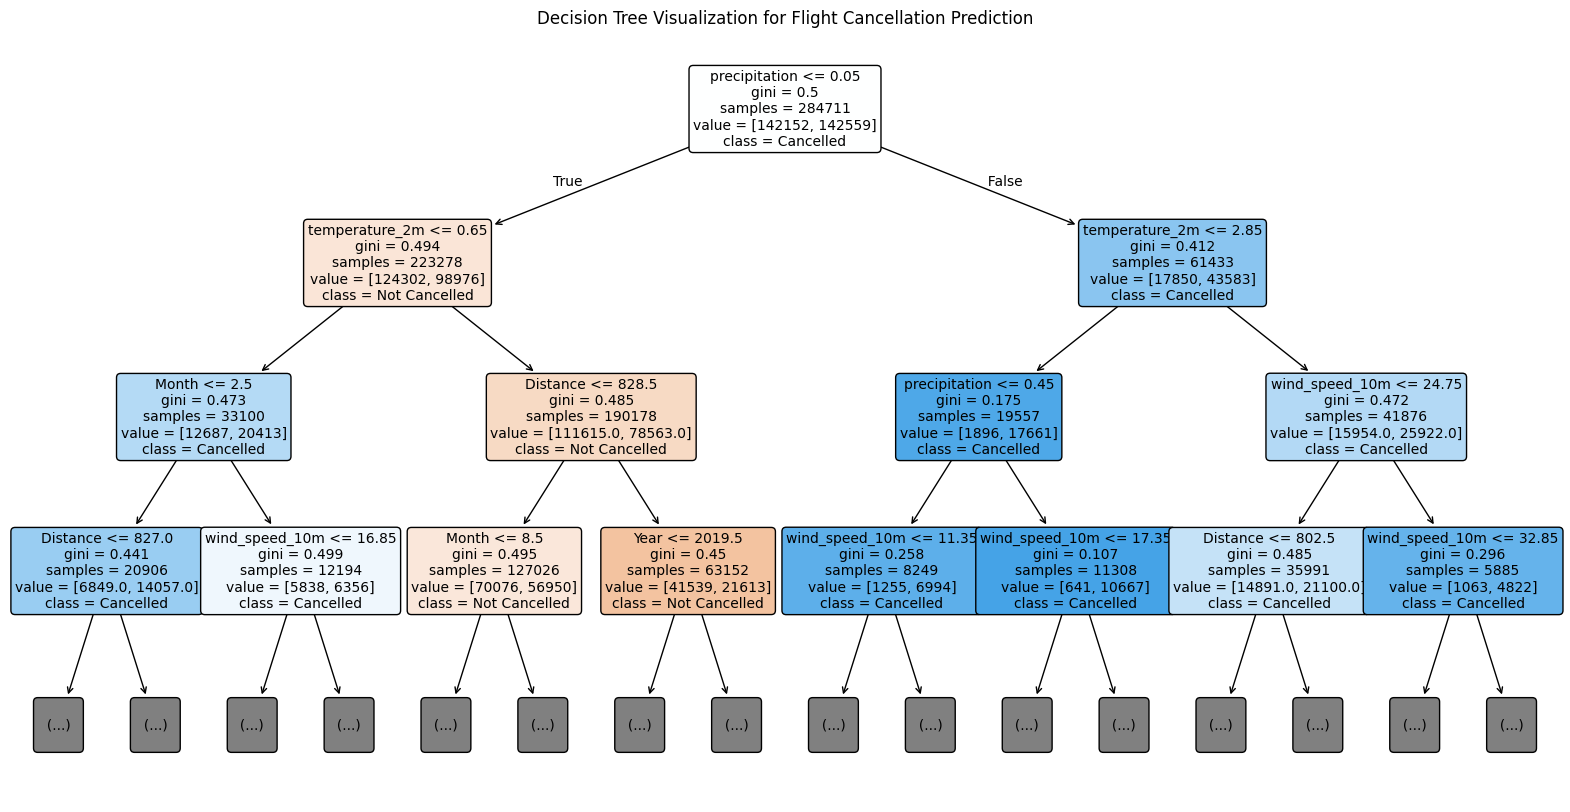

In [13]:

plt.figure(figsize=(20, 10))  
plot_tree(
    model,
    feature_names=X_important.columns, 
    class_names=["Not Cancelled", "Cancelled"],
    filled=True,
    rounded=True,
    fontsize=10, 
    max_depth=3  
)
plt.title("Decision Tree Visualization for Flight Cancellation Prediction")
plt.show()

### Saving model and results

In [14]:
import pickle

# Save the model to a file using pickle
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved to 'decision_tree_model.pkl'")

Model saved to 'decision_tree_model.pkl'


In [15]:
from sklearn.tree import export_text

# Generate a text representation of the decision tree
tree_text = export_text(
    model,
    feature_names=list(X_important.columns)  
)

# Print the text representation
print(tree_text)

|--- precipitation <= 0.05
|   |--- temperature_2m <= 0.65
|   |   |--- Month <= 2.50
|   |   |   |--- Distance <= 827.00
|   |   |   |   |--- class: 1.0
|   |   |   |--- Distance >  827.00
|   |   |   |   |--- class: 1.0
|   |   |--- Month >  2.50
|   |   |   |--- wind_speed_10m <= 16.85
|   |   |   |   |--- class: 0.0
|   |   |   |--- wind_speed_10m >  16.85
|   |   |   |   |--- class: 1.0
|   |--- temperature_2m >  0.65
|   |   |--- Distance <= 828.50
|   |   |   |--- Month <= 8.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- Month >  8.50
|   |   |   |   |--- class: 0.0
|   |   |--- Distance >  828.50
|   |   |   |--- Year <= 2019.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- Year >  2019.50
|   |   |   |   |--- class: 1.0
|--- precipitation >  0.05
|   |--- temperature_2m <= 2.85
|   |   |--- precipitation <= 0.45
|   |   |   |--- wind_speed_10m <= 11.35
|   |   |   |   |--- class: 1.0
|   |   |   |--- wind_speed_10m >  11.35
|   |   |   |   |--- class: 1.0
|   |   |--- 

In [16]:
# Load the model from the pickle file
with open('decision_tree_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [17]:
# Load the pickled model
with open('decision_tree_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Actuality will use unseen data, this is just an example
new_data = X_important.head(3)  
actual_labels = y.head(3)  

# Make predictions
predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)

# Create a DataFrame to display actual, predicted, and probabilities
results = pd.DataFrame({
    'Actual': actual_labels,
    'Predicted': predictions,
    'Probability_Not_Cancelled': probabilities[:, 0],  # Probability of class 0
    'Probability_Cancelled': probabilities[:, 1]       # Probability of class 1
})

# Concatenate the feature columns horizontally with results DataFrame
results = pd.concat([results.reset_index(drop=True), new_data.reset_index(drop=True)], axis=1)

# Display the results table
print(results)

# Convert DataFrame to CSV in memory
csv_buffer = StringIO()
results.to_csv(csv_buffer, index=False)


s3_client = boto3.client('s3', region_name='us-east-1') 


bucket_name = 'is459-project-output-data' 
file_path = 'weather/Prediction/results.csv' 

# Upload the CSV file to S3
s3_client.put_object(Bucket=bucket_name, Key=file_path, Body=csv_buffer.getvalue())

print(f"File successfully uploaded to s3://{bucket_name}/{file_path}")



   Actual  Predicted  Probability_Not_Cancelled  Probability_Cancelled  \
0     0.0        0.0                   0.519227               0.480773   
1     0.0        0.0                   0.674648               0.325352   
2     0.0        0.0                   0.674648               0.325352   

   temperature_2m  wind_speed_10m  CRSArrTime  CRSDepTime  DayofMonth  \
0            14.6             1.8        1453        1342          11   
1            17.1             6.4         916         630           5   
2            24.0            24.9        1925        1629          20   

   Distance  CRSElapsedTime  Month  Year  precipitation  rain  
0     326.0            71.0      8  2010            0.0   0.0  
1     919.0           166.0      9  2016            0.0   0.0  
2     950.0           176.0      9  2017            0.0   0.0  
File successfully uploaded to s3://is459-project-output-data/weather/Prediction/results.csv


## END--

## Weather cancellation among cancellations


In [20]:
# Filter for canceled flights only
df_canceled = df[df['Cancelled'] == 1]

# Create a new target variable for weather-related cancellations
df_canceled['WeatherCancellation'] = (df_canceled['CancellationCode'] == 'B').astype(int)

important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSArrTime', 'CRSDepTime', 'precipitation','rain',
    'DayofMonth', 'Distance', 'CRSElapsedTime', 'Month', 'Year'
]


X_important = df_canceled[important_features]
y = df_canceled['WeatherCancellation']


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)

# Apply undersampling to the training data
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


model = DecisionTreeClassifier(random_state=42, min_samples_split=10, min_samples_leaf=5, max_depth=4)
model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

#Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6601212915915424
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.74      0.69     31777
           1       0.67      0.58      0.62     29233

    accuracy                           0.66     61010
   macro avg       0.66      0.66      0.66     61010
weighted avg       0.66      0.66      0.66     61010

Confusion Matrix:
 [[23446  8331]
 [12405 16828]]


### Feature Importance

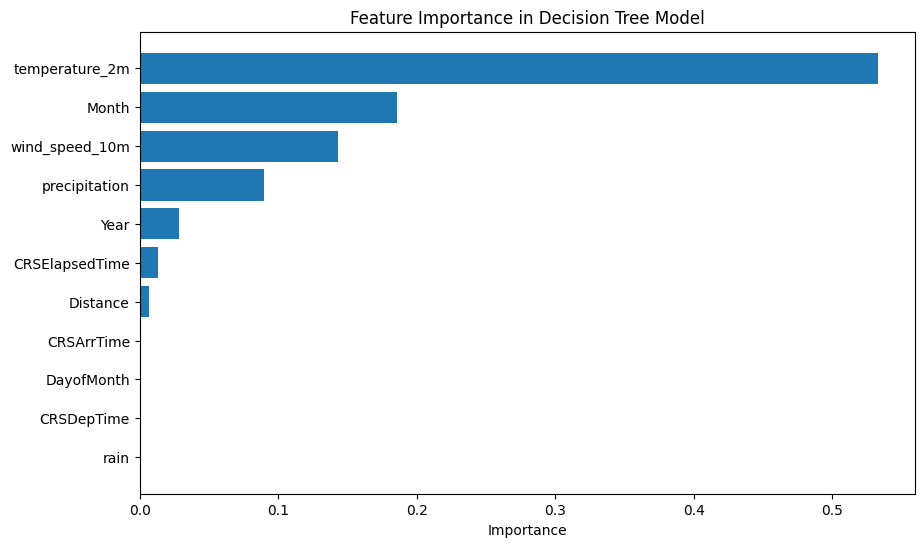

In [39]:

feature_importance = pd.DataFrame({
    'Feature': X_important.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()


### Partial Dependence

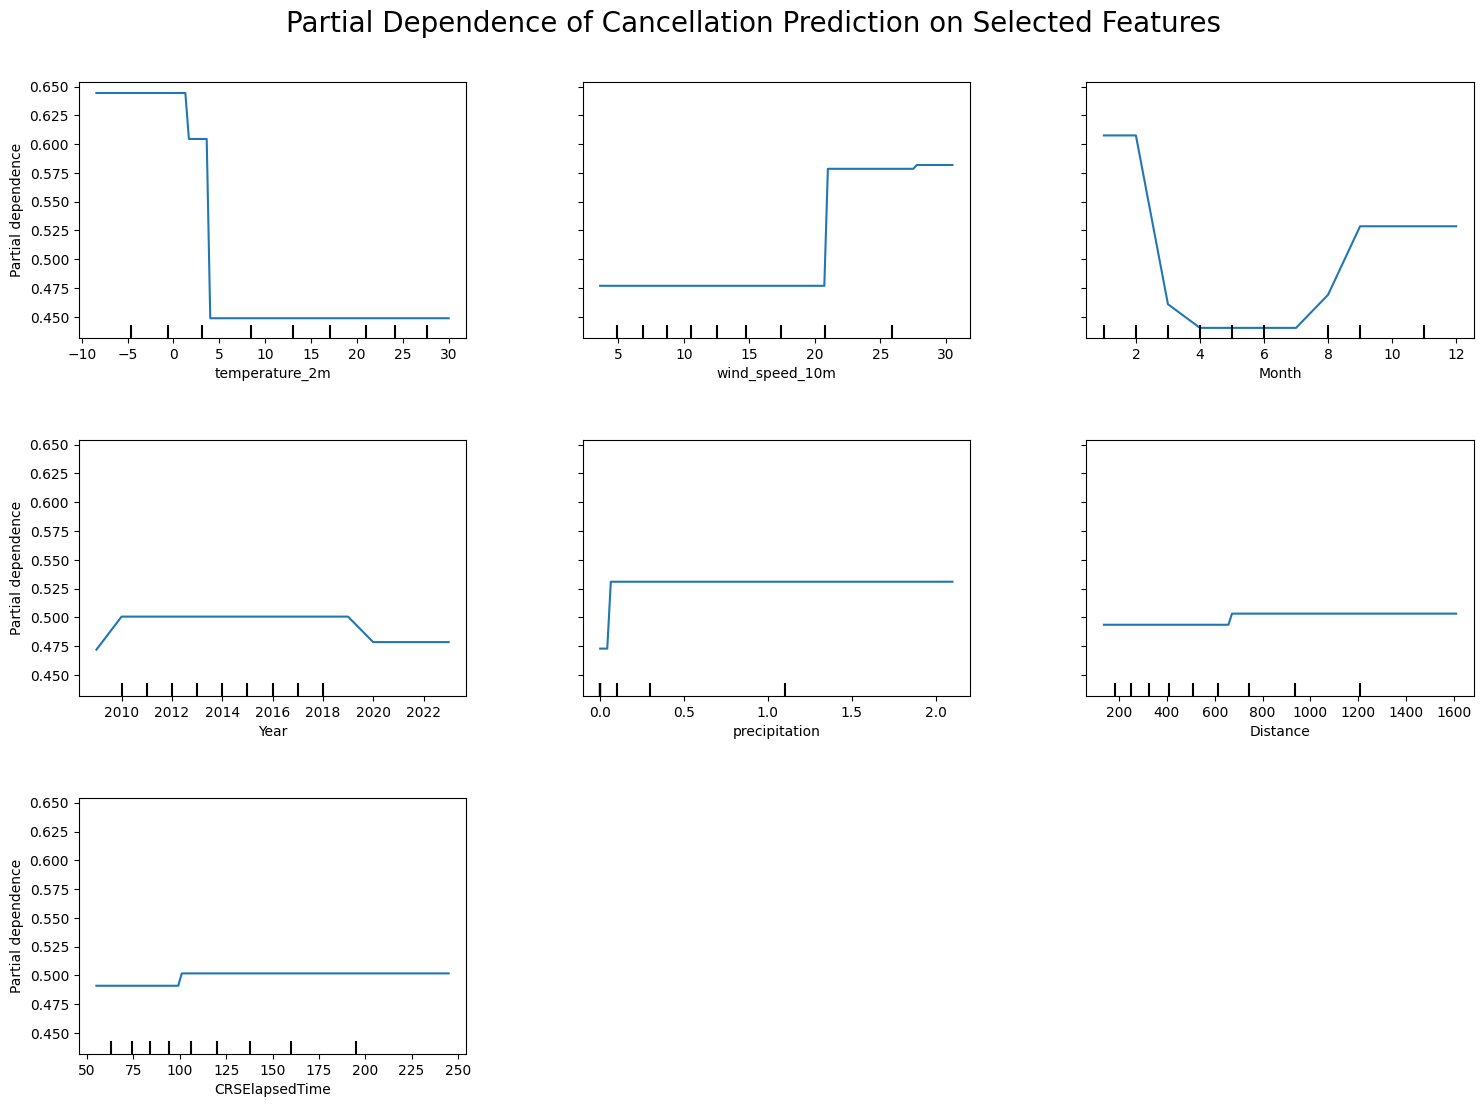

In [40]:

important_features = ['temperature_2m', 'wind_speed_10m', 'Month', 'Year', 'precipitation', 'Distance','CRSElapsedTime']


fig, ax = plt.subplots(figsize=(18, 12))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    important_features,
    kind="average",
    n_cols=3, 
    ax=ax
)


plt.suptitle("Partial Dependence of Cancellation Prediction on Selected Features", fontsize=20)
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  # Adjust spacing for clarity


plt.show()



### Visualize the Decision Tree

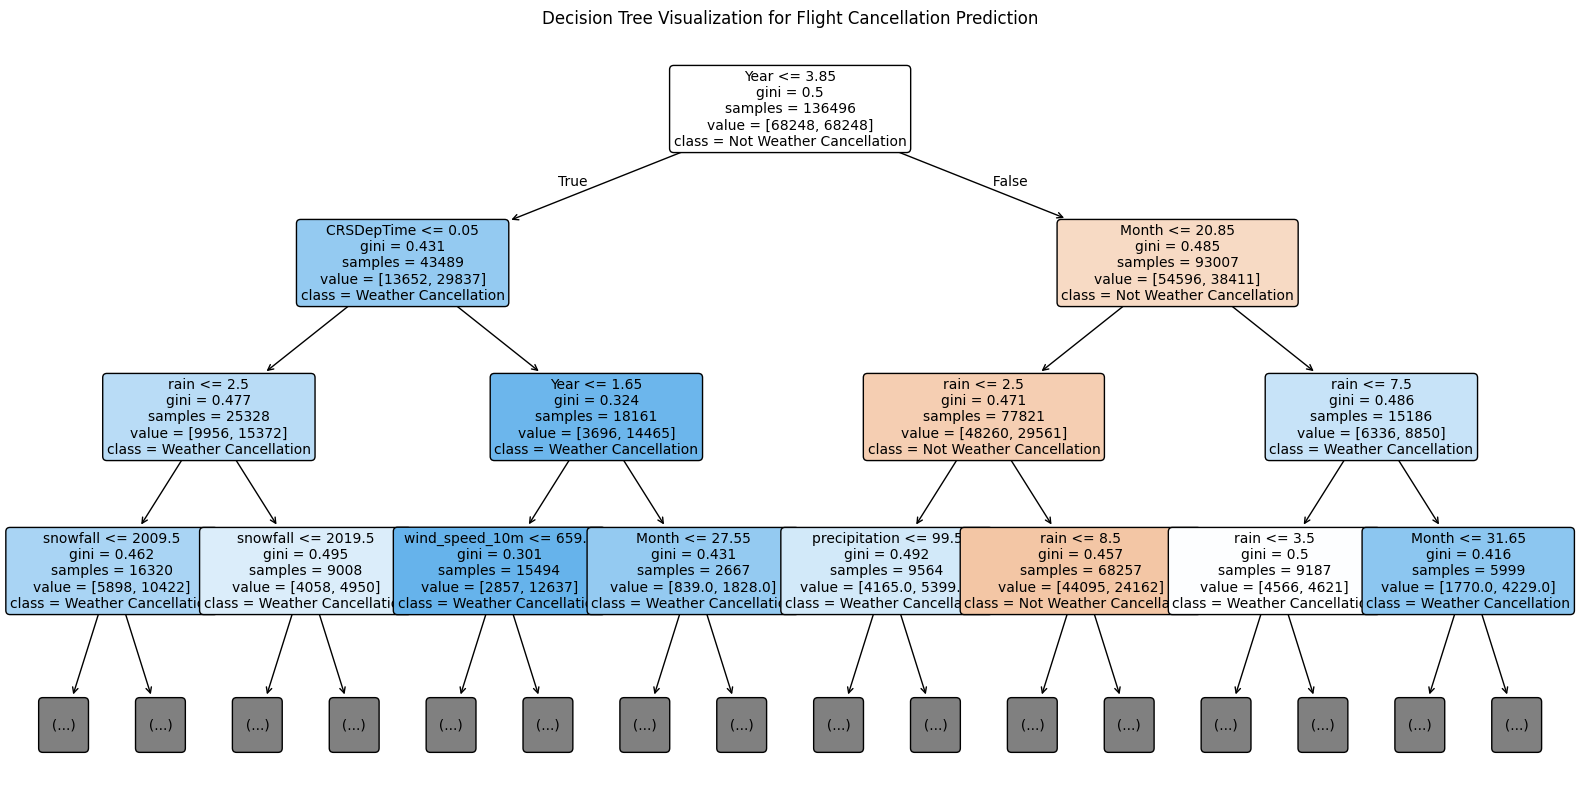

In [49]:

plt.figure(figsize=(20, 10))  
plot_tree(
    model,
    feature_names=X.columns, 
    class_names=["Not Weather Cancellation", "Weather Cancellation"],
    filled=True,
    rounded=True,
    fontsize=10, 
    max_depth=3  
)
plt.title("Decision Tree Visualization for Flight Cancellation Prediction")
plt.show()



In [50]:
import pickle

# Save the model to a file using pickle
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved to 'decision_tree_model.pkl'")


Model saved to 'decision_tree_model.pkl'


In [53]:
from sklearn.tree import export_text

# Generate a text representation of the decision tree
tree_text = export_text(
    model,
    feature_names=list(X_important.columns)  
)

# Print the text representation
print(tree_text)



|--- temperature_2m <= 3.85
|   |--- precipitation <= 0.05
|   |   |--- Month <= 2.50
|   |   |   |--- Year <= 2009.50
|   |   |   |   |--- class: 0
|   |   |   |--- Year >  2009.50
|   |   |   |   |--- class: 1
|   |   |--- Month >  2.50
|   |   |   |--- Year <= 2019.50
|   |   |   |   |--- class: 1
|   |   |   |--- Year >  2019.50
|   |   |   |   |--- class: 0
|   |--- precipitation >  0.05
|   |   |--- temperature_2m <= 1.65
|   |   |   |--- Distance <= 659.50
|   |   |   |   |--- class: 1
|   |   |   |--- Distance >  659.50
|   |   |   |   |--- class: 1
|   |   |--- temperature_2m >  1.65
|   |   |   |--- wind_speed_10m <= 27.55
|   |   |   |   |--- class: 1
|   |   |   |--- wind_speed_10m >  27.55
|   |   |   |   |--- class: 1
|--- temperature_2m >  3.85
|   |--- wind_speed_10m <= 20.85
|   |   |--- Month <= 2.50
|   |   |   |--- CRSElapsedTime <= 99.50
|   |   |   |   |--- class: 0
|   |   |   |--- CRSElapsedTime >  99.50
|   |   |   |   |--- class: 1
|   |   |--- Month >  2.50
|

In [ ]:

# Load the model from the pickle file
with open('decision_tree_model.pkl', 'rb') as file:
    model = pickle.load(file)


#### Example of using prediction model

In [65]:

# Load the pickled model
with open('decision_tree_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Actuality will use unseen data, this is just an example
new_data = X_important.head(3)  
actual_labels = y.head(3)  

# Make predictions
predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)

# Create a DataFrame to display actual, predicted, and probabilities
results = pd.DataFrame({
    'Actual': actual_labels,
    'Predicted': predictions,
    'Probability_Not_Weather': probabilities[:, 0],  # Probability of class 0
    'Probability_Weather': probabilities[:, 1]       # Probability of class 1
})

# Concatenate the feature columns horizontally with results DataFrame
results = pd.concat([results.reset_index(drop=True), new_data.reset_index(drop=True)], axis=1)

# Display the results table
print(results)

# Convert DataFrame to CSV in memory
csv_buffer = StringIO()
results.to_csv(csv_buffer, index=False)


s3_client = boto3.client('s3', region_name='us-east-1') 


bucket_name = 'is459-project-output-data' 
file_path = 'weather/Prediction/results.csv' 

# Upload the CSV file to S3
s3_client.put_object(Bucket=bucket_name, Key=file_path, Body=csv_buffer.getvalue())

print(f"File successfully uploaded to s3://{bucket_name}/{file_path}")




   Actual  Predicted  Probability_Not_Weather  Probability_Weather  \
0       1          1                 0.130631             0.869369   
1       1          1                 0.346455             0.653545   
2       0          0                 0.583995             0.416005   

   temperature_2m  wind_speed_10m  CRSArrTime  CRSDepTime  precipitation  \
0             1.1            37.1        2245        2125            0.2   
1           -14.7             7.3        1705        1529            0.0   
2            10.5            21.0         726         600            5.4   

   rain  DayofMonth  Distance  CRSElapsedTime  Month  Year  
0   0.2          13     764.0           140.0      2  2014  
1   0.0          11     430.0            96.0      2  2014  
2   5.4          26     280.0            86.0      5  2017  
File successfully uploaded to s3://is459-project-output-data/weather/Prediction/results.csv


In [8]:
# Filter the DataFrame for rows where Cancelled is 1
cancelled_df = df[df['Cancelled'] == 1]

# Display the first few rows of the filtered DataFrame
print(cancelled_df.isnull().sum())

len(cancelled_df)

Date                      0
Year                      0
Month                     0
DayofMonth                0
UniqueCarrier             0
FlightNum                 0
Origin                    0
Dest                      0
CRSDepTime                0
DepTime              195931
DepDelay             195983
ArrTime              203365
ArrDelay             203365
Cancelled                 0
Diverted                  0
AirTime              203365
Distance                  0
CarrierDelay              0
WeatherDelay              0
NASDelay                  0
LateAircraftDelay         0
CRSArrTime                0
ActualElapsedTime    203365
CRSElapsedTime           11
TaxiIn               203365
TaxiOut              201478
CancellationCode          0
SecurityDelay             0
temperature_2m            0
wind_speed_10m            0
precipitation             0
rain                      0
snowfall                  0
longitude                 0
latitude                  0
CRSDepHour          

203365

In [7]:
# Filter for canceled flights
cancelled_df = df[df['Cancelled'] == 1]

# Check if there are any non-zero delays in the delay columns
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']
delays_in_cancelled = cancelled_df[delay_columns].sum()

# Display results
print("Total delays in canceled flights:")
print(delays_in_cancelled)

# Check if there are any records with non-zero delay values in canceled flights
has_delays = (cancelled_df[delay_columns] > 0).any().any()
if has_delays:
    print("\nSome canceled flights have recorded delays in one or more delay columns.")
else:
    print("\nNo canceled flights have recorded delays in the delay columns.")


Total delays in canceled flights:
CarrierDelay         0.0
WeatherDelay         0.0
NASDelay             0.0
LateAircraftDelay    0.0
dtype: float64

No canceled flights have recorded delays in the delay columns.


In [ ]:
#Not using Carrier
# One-hot encode the 'UniqueCarrier' column 
df_encoded = pd.get_dummies(df, columns=['UniqueCarrier'], prefix='Carrier', drop_first=True)

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())
# Get the names of all 'UniqueCarrier' one-hot encoded columns
carrier_columns = [col for col in df_encoded.columns if col.startswith('Carrier_')]


## All Cancellations


In [20]:
# Select relevant features for feature importance
selected_features = [
    'Year', 'Month', 'DayofMonth','Distance',
    'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime',
    'temperature_2m', 'wind_speed_10m', 'precipitation', 'rain', 'snowfall']
# 'DepTime','ArrTime','ActualElapsedTime','TaxiOut','TaxiIn',
selected_features += carrier_columns

X = df_encoded[selected_features]
y = df_encoded['Cancelled'] 


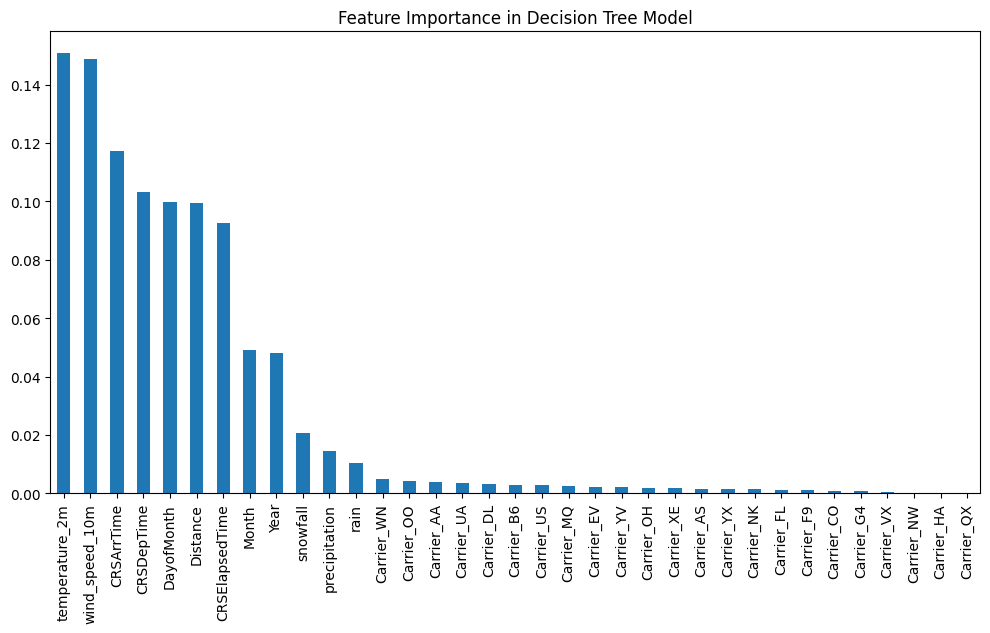

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Decision Tree Model")
plt.show()


In [22]:
# Define the list of important features based on the plot
important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSArrTime', 'CRSDepTime', 'precipitation','rain',
    'DayofMonth', 'Distance', 'CRSElapsedTime', 'Month', 'Year'
]

# Use only the selected important features for training
X_important = df_encoded[important_features]
y = df['Cancelled'] 


### Cancelled flights


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   1846412
         1.0       0.64      0.03      0.06     30611

    accuracy                           0.98   1877023
   macro avg       0.81      0.52      0.53   1877023
weighted avg       0.98      0.98      0.98   1877023



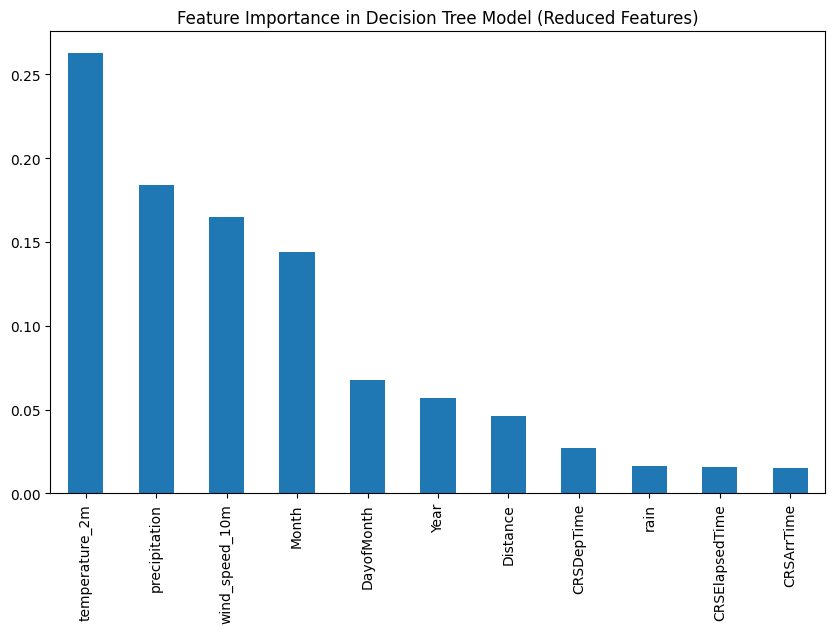

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance for the reduced model
feature_importance = pd.Series(model.feature_importances_, index=X_important.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Decision Tree Model (Reduced Features)")
plt.show()


#

Recall = 0.03: Out of all actual canceled flights, only 3% were correctly identified.
F1-score = 0.06: The low F1-score indicates that the model struggles to correctly identify canceled flights.

## Predict CancellationCode-weather


In [9]:
# Select relevant features for feature importance
selected_features = [
    'Year', 'Month', 'DayofMonth','Distance',
    'CRSDepTime', 'CRSArrTime',
    'temperature_2m', 'wind_speed_10m', 'precipitation', 'rain', 'snowfall']

df['WeatherCancellation'] = (df['CancellationCode'] == 'B').astype(int)
X = df[selected_features]
y = df['WeatherCancellation'] 

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Step 3: Train a Decision Tree model with undersampled data
model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Step 4: Predict on the Test Set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7720676114733798
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87   2483097
           1       0.02      0.63      0.04     19496

    accuracy                           0.77   2502593
   macro avg       0.51      0.70      0.46   2502593
weighted avg       0.99      0.77      0.86   2502593

Confusion Matrix:
 [[1919980  563117]
 [   7305   12191]]


In [22]:
# Create a new target variable for weather-related cancellations
df['HaveWeatherDelay'] = (df['WeatherDelay'] >15).astype(int)

# Select important features for the prediction
important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSDepTime', 'precipitation',
    'DayofMonth', 'Distance',  'Month', 'Year'
]

# Define the feature set (X) and the new target variable (y)
X_important = df[important_features]
y = df['HaveWeatherDelay']

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   3729555
           1       0.19      0.00      0.00     24335

    accuracy                           0.99   3753890
   macro avg       0.59      0.50      0.50   3753890
weighted avg       0.99      0.99      0.99   3753890



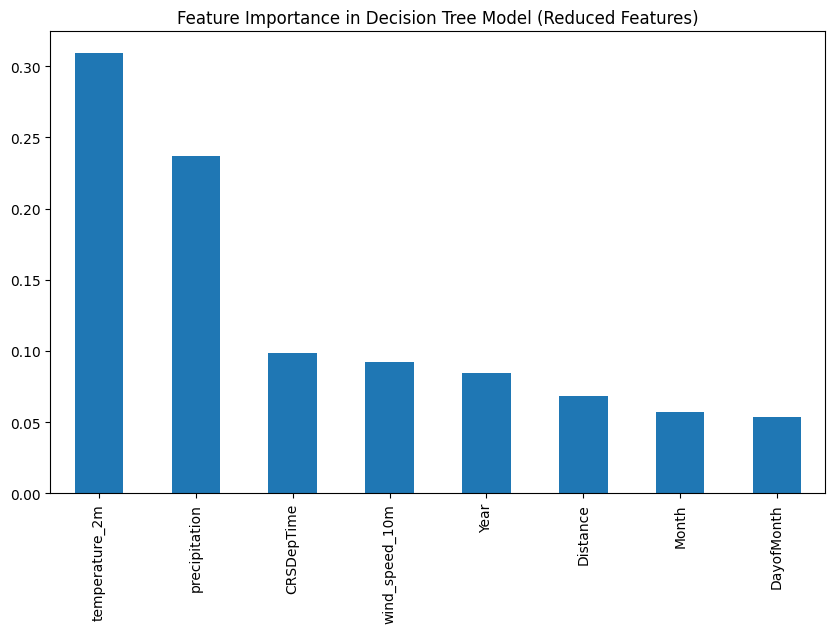

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance for the reduced model
feature_importance = pd.Series(model.feature_importances_, index=X_important.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Decision Tree Model (Reduced Features)")
plt.show()

#### undersampling non cancellation


In [12]:
from imblearn.under_sampling import RandomUnderSampler
important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSArrTime', 'CRSDepTime',
    'DayofMonth', 'Distance', 'CRSElapsedTime', 'Month', 'Year','precipitation','rain'
]

# Use only the selected important features for training
X_important = df[important_features]
y = df['Cancelled']  # Assuming 'Cancelled' is the target variable
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_important, y)


              precision    recall  f1-score   support

         0.0       0.63      0.79      0.70     61213
         1.0       0.71      0.53      0.61     60806

    accuracy                           0.66    122019
   macro avg       0.67      0.66      0.65    122019
weighted avg       0.67      0.66      0.65    122019



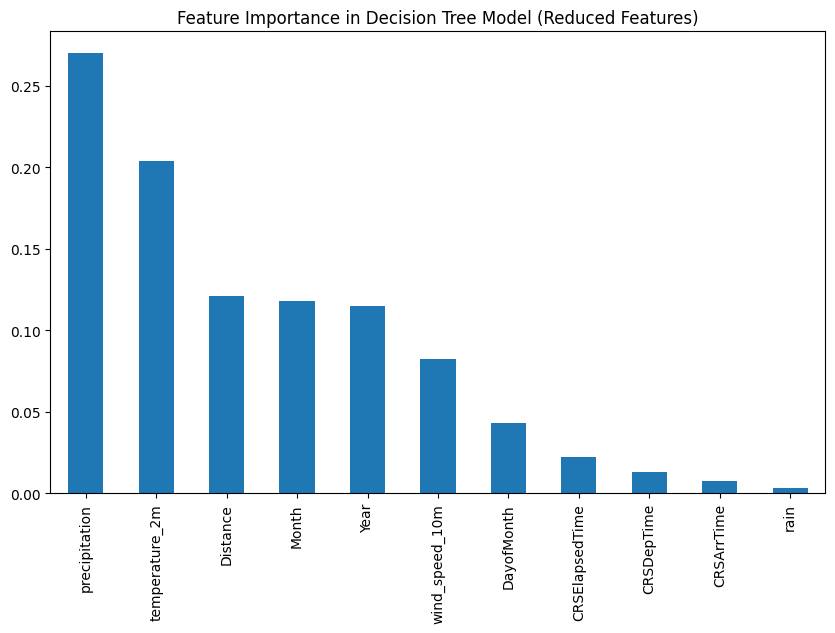

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance for the reduced model
feature_importance = pd.Series(model.feature_importances_, index=X_important.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Decision Tree Model (Reduced Features)")
plt.show()

### RF weather delay>15


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Load your dataset (replace with your actual data loading code)
# Assuming 'WeatherDelay' is in minutes and contains numerical values
# df = pd.read_csv('your_data.csv')

# Step 1: Create Binary Target Variable for Weather Delay > 15 Minutes
df['WeatherDelay_Over15'] = (df['WeatherDelay'] > 15).astype(int)

# Separate features and the new target
target_column = 'WeatherDelay_Over15'
important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSDepTime','precipitation',
    'DayofMonth', 'Distance', 'Month', 'Year'
]

# Use only the selected important features for training
X_important = df[important_features]
y = df[target_column]

# Step 2: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Train a Random Forest Model
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 4: Predict and Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of delay > 15

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_rep)

results = pd.DataFrame({
    'PredictedDelayOver15': y_pred,
    'DelayProbability': y_prob
})

# Add the important features from X_test to the results DataFrame
for feature in important_features:
    results[feature] = X_test[feature].values

# Display the first few rows of the results
print(results.head())

Accuracy: 0.9935123290123484
ROC AUC Score: 0.7317567975503106
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00   2486408
           1       0.48      0.05      0.09     16185

    accuracy                           0.99   2502593
   macro avg       0.74      0.52      0.54   2502593
weighted avg       0.99      0.99      0.99   2502593

   PredictedDelayOver15  DelayProbability  temperature_2m  wind_speed_10m  \
0                     0              0.00            19.1            22.6   
1                     0              0.00            18.2             7.6   
2                     0              0.02            28.5             4.3   
3                     0              0.00            21.0             5.9   
4                     0              0.00             2.1            15.9   

   CRSDepTime  precipitation  DayofMonth  Distance  Month  Year  
0        1520            0.3          16     746.0      5

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Load your dataset (replace with your actual data loading code)
# Assuming 'WeatherDelay' is in minutes and contains numerical values
# df = pd.read_csv('your_data.csv')

# Step 1: Create Binary Target Variable for Weather Delay > 15 Minutes
df['WeatherCancelled'] = (df['CancellationCode'] =='B' ).astype(int)

# Separate features and the new target
target_column = 'WeatherCancelled'
important_features = [
    'temperature_2m', 'wind_speed_10m', 'CRSArrTime', 'CRSDepTime',
    'DayofMonth', 'Distance', 'CRSElapsedTime', 'Month', 'Year'
]

# Use only the selected important features for training
X_important = df[important_features]
y = df[target_column]

# Step 2: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Train a Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 4: Predict and Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of delay > 15

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_rep)

# Optional: Show the first few predictions with probabilities
results = pd.DataFrame({
    'FlightNum': X_test.index,  # Assuming FlightID is an index or part of the data
    'PredictedDelayOver15': y_pred,
    'DelayProbability': y_prob
})
print(results.head())
